# fBox
Dans ce notebook, nous implémenterons l'algorithme fBox à partir du papier de recherche
## Importations

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

from scipy.sparse import csr_matrix, lil_matrix
from scipy.sparse.csgraph import connected_components
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import svds, eigs
from scipy.io import savemat, loadmat
import os

import pylab

## Définition d'une fonction pour tracer les graphes

In [2]:
def plot_graph(A):
    G = nx.DiGraph()
    for count,value in enumerate(A):
        for count2, value2 in enumerate(value):
            if (value2 != 0):
                G.add_edges_from([(str(count), str(count2))], weight=value2)

    edge_labels=dict([((u,v,),d['weight'])
                    for u,v,d in G.edges(data=True)])

    pos=nx.spring_layout(G)
    
    nx.draw_networkx_edge_labels(G,pos,edge_labels=edge_labels)
    nx.draw(G,pos,edge_cmap=plt.cm.Reds,with_labels = True)
    pylab.show()

In [3]:
#==========   Initialisation
pcthresh = 1
degthresh = 2
neigs = 3#Utilite enleve

graph = [
    [0, 5 ,2 ,4],
    [1, 0, 5, 3],
    [ 5 ,5 ,5, 0],
    [ 0, 0, 0, 0],
]

graph = np.array(graph)

adj = csc_matrix(graph, dtype=float)

  (1, 0)	1.0
  (2, 0)	5.0
  (0, 1)	5.0
  (2, 1)	5.0
  (0, 2)	2.0
  (1, 2)	5.0
  (2, 2)	5.0
  (0, 3)	4.0
  (1, 3)	3.0


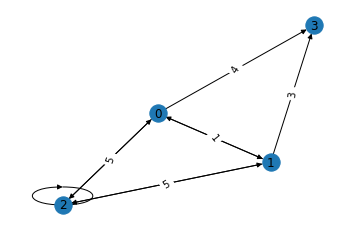

In [4]:
#============ On affiche le graphe de liens
print(adj)
plot_graph(graph)

In [5]:
A = adj.toarray()
mat = loadmat('../data_parsed/data_amz.mat')
adj = mat['M'].asfptype()
adj = adj.transpose()

## Implémentation du code
### Implémentation à partir du Pseudo-code

In [6]:
def fbox(A, k, t):
    userCulprits   = []
    objectCulprits = []
    outDegrees     = np.sum(A, 0)
    inDegrees      = np.sum(A, 1)
    U, S, V        = svds(A, k=k,which="LM",return_singular_vectors=True)
    

    print("nb out degre 0 (5)",outDegrees[0,1])# doit etre a 5
    print("nb out degre 0 (1)",inDegrees[1,0])# doit etre a 1


    S = np.diag(S) # Permet d'avoir une matrice
    recOutDegs = np.square(np.linalg.norm( U @ S,axis=1))
    recInDegs  = np.square(np.linalg.norm( np.transpose(V) @ S,axis=1))
    
    uniqueOutDegrees = np.unique(np.array(outDegrees))
    uniqueInDegrees  = np.unique(np.array(inDegrees))
    

    for od in uniqueOutDegrees:
        nodeSet = np.where(uniqueOutDegrees == od)[0]
        recOutDegSet = recOutDegs[nodeSet]
        recThreshold = np.percentile(recOutDegSet, t)
        for n in nodeSet:
            if(recOutDegs[n] <= recThreshold):
                userCulprits.append(n)
            
    for ind in uniqueInDegrees:
        nodeSet = np.where(uniqueInDegrees == ind)[0]
        recInDegSet = recInDegs[nodeSet]
        recThreshold = np.percentile(recInDegSet, t)
        for n in nodeSet:
            if(recInDegs[n] <= recThreshold):
                objectCulprits.append(n)
    
    return userCulprits, objectCulprits

### Implémentation à partir du code MATLAB

In [7]:
def quantile(x,q): # equivalent de np.quantile
    n = len(x)
    y = np.sort(x)
    return(np.interp(q, np.linspace(1/(2*n), (2*n-1)/(2*n), n), y))

def prctile(x,p): # equivalent matlab
    return(np.quantile(x,np.array(p)/100))

def find(cond): # equivalent matlab
    return np.where(cond)

#Version matlab de son algo
def m_fbox(A, k, t):

    U,S,V = svds(A,k=k,which="LM",return_singular_vectors=True)
    S = np.diag(S)
    V = np.transpose(V)
    
    # On inverse l'ordre des colonnes et on multiplie par -1
    U = -1 * np.fliplr(U)
    V = -1 * np.fliplr(V)
    S =  np.fliplr(S)
    S = np.flipud(S)

    indegs = np.sum(A,axis=0).A1 # On retransforme la matrice sous forme array
    outdegs = np.sum(A,axis=1).A1

    rec_indegs = np.sum(np.matmul(V,S) ** 2,axis=1) # Même que matlab
    rec_outdegs = np.sum(np.matmul(U,S) ** 2,axis=1) # Même que matlab


    q = np.unique(np.array(indegs))
    lq = len(q)

    # On pourrait changer en array de tuple
    trackpct_indegs = lil_matrix((lq,2))

    for i in range(0,lq):
        deg = q[i]
        trackpct_indegs[i,0] = deg
        indices = find(indegs == deg)
        vsub = V[indices,:]
        rdegs = np.sum( np.matmul(vsub,S) **2,axis=1)
        trackpct_indegs[i,1] = prctile(rdegs,pcthresh)
        

    q = np.unique(np.array(outdegs))
    lq = len(q)
    trackpct_outdegs = lil_matrix((lq,2))
    for i in range(0,lq):
        deg = q[i]
        trackpct_outdegs[i,0] = deg
        indices = find(outdegs == deg)
        usub = U[indices,:]
        rdegs = np.sum( np.matmul(usub,S) **2,axis=1)
        trackpct_outdegs[i,1] = prctile(rdegs,pcthresh)

    
    isub = find(indegs > degthresh)[0]
    osub = find(outdegs > degthresh)[0]

    iculprits = []
    oculprits = []
    
    for node in isub:

        f = find(trackpct_indegs[:,0].toarray() == indegs[node])[0]
        if rec_indegs[node] < trackpct_indegs[f,1]:
            iculprits.append((node,indegs[node]))


    for node in osub:
        f = find(trackpct_outdegs[:,0].toarray() == outdegs[node])[0]
        if rec_outdegs[node] < trackpct_outdegs[f,1]:
            oculprits.append((node,outdegs[node]))
    

    return iculprits,oculprits

## Test de l'algorithme fBox Pseudo-code

In [8]:
pcthresh = 2
neigs = 50

userCulprits, objectCulprits = fbox(adj, neigs, pcthresh)
print("user culprits : ",len(userCulprits))
print(userCulprits)
print("object culprits : ",len(objectCulprits))
print(objectCulprits)

nb out degre 0 (5) 5.0
nb out degre 0 (1) 1.0
user culprits :  6
[0, 1, 2, 3, 4, 5]
object culprits :  157
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156]


## Test de l'algorithme fBox Pseudo-code

In [9]:
pcthresh = 0.3
neigs = 50

#Fait un resultat enorme (241k)
userCulprits, objectCulprits = m_fbox(adj, neigs, pcthresh)
print("user culprits : ",len(userCulprits))
print(userCulprits)
print("object culprits : ",len(objectCulprits))
print(objectCulprits)

user culprits :  246983
[(0, 5.0), (1, 5.0), (2, 5.0), (3, 5.0), (4, 5.0), (5, 5.0), (6, 5.0), (7, 5.0), (8, 5.0), (10, 5.0), (11, 5.0), (12, 5.0), (13, 5.0), (14, 5.0), (15, 5.0), (16, 5.0), (17, 5.0), (18, 5.0), (19, 5.0), (20, 5.0), (21, 5.0), (22, 5.0), (23, 5.0), (24, 5.0), (25, 4.0), (26, 5.0), (27, 5.0), (28, 5.0), (29, 5.0), (30, 5.0), (31, 5.0), (32, 5.0), (33, 5.0), (34, 5.0), (35, 5.0), (36, 5.0), (37, 5.0), (38, 5.0), (39, 5.0), (40, 5.0), (41, 5.0), (42, 5.0), (43, 5.0), (44, 5.0), (45, 5.0), (46, 5.0), (47, 5.0), (48, 5.0), (49, 5.0), (50, 5.0), (51, 5.0), (52, 5.0), (53, 5.0), (54, 5.0), (55, 5.0), (56, 5.0), (57, 5.0), (58, 5.0), (59, 5.0), (60, 5.0), (61, 5.0), (62, 5.0), (63, 5.0), (64, 5.0), (65, 5.0), (66, 5.0), (67, 5.0), (69, 5.0), (70, 5.0), (71, 5.0), (72, 5.0), (73, 5.0), (74, 5.0), (75, 5.0), (76, 5.0), (77, 5.0), (78, 5.0), (79, 5.0), (80, 5.0), (81, 5.0), (82, 5.0), (83, 5.0), (84, 5.0), (85, 5.0), (86, 5.0), (87, 5.0), (88, 5.0), (89, 5.0), (90, 5.0), (91, 

[(14, 13.0), (16, 6.0), (25, 9.0), (26, 12.0), (43, 10.0), (44, 10.0), (45, 5.0), (46, 5.0), (47, 4.0), (50, 4.0), (55, 5.0), (59, 6.0), (62, 5.0), (64, 5.0), (65, 8.0), (66, 7.0), (68, 12.0), (69, 6.0), (70, 4.0), (71, 6.0), (72, 7.0), (73, 4.0), (74, 4.0), (75, 6.0), (85, 4.0), (87, 3.0), (88, 5.0), (90, 6.0), (91, 4.0), (92, 4.0), (102, 5.0), (103, 4.0), (104, 4.0), (105, 9.0), (106, 6.0), (107, 6.0), (108, 6.0), (109, 4.0), (110, 3.0), (115, 8.0), (116, 9.0), (120, 16.0), (122, 3.0), (123, 4.0), (124, 11.0), (125, 11.0), (126, 8.0), (127, 9.0), (128, 7.0), (129, 6.0), (130, 7.0), (131, 5.0), (135, 5.0), (136, 3.0), (140, 6.0), (141, 5.0), (144, 6.0), (145, 11.0), (146, 3.0), (153, 3.0), (157, 9.0), (169, 3.0), (172, 4.0), (173, 7.0), (175, 4.0), (177, 4.0), (178, 5.0), (179, 4.0), (184, 5.0), (185, 3.0), (187, 4.0), (188, 5.0), (198, 8.0), (199, 4.0), (200, 9.0), (207, 11.0), (208, 3.0), (211, 12.0), (213, 6.0), (215, 20.0), (219, 4.0), (220, 8.0), (221, 4.0), (222, 9.0), (223, 19.

## Test de l'algorithme fBox UGFraud

In [10]:
from numpy.linalg import *

def run(matrix,tau, k):
    """
        run the algorithm.
        tau: the percentile in reconstructed degree threshold under which a node is considered suspicious
    """
    # k = 50 is selected based on Figure 3 of the paper
    
    num_users,num_products  = matrix.shape

    u, s, vt = svds(matrix, k=k)
    # reconstructed out degree
    recOutDeg = norm(u.dot(np.diag(s)), axis=1)
    # reconstructed in degree
    recInDeg = norm(vt.T.dot(np.diag(s)), axis=1)

    # detect users
    out_deg = matrix.sum(axis=1)
    out_deg = np.array(out_deg).reshape(-1, )
    unique_out_deg = np.unique(out_deg)

    # store the indices of suspicious users
    suspicious_users = {}
    thresholds = {}
    for d in unique_out_deg:
        # find users with original degree = d
        users = (out_deg == d)
        user_deg = recOutDeg[users]
        thresholds[d] = np.percentile(user_deg, tau)

    for i in range(num_users):
        user_d = out_deg[i]
        if recOutDeg[i] < thresholds[user_d]:

            if user_d not in suspicious_users:
                suspicious_users[user_d] = []
            suspicious_users[user_d].append(i)

    # detect products
    in_deg = matrix.sum(axis=0)
    in_deg = np.array(in_deg).reshape(-1, )
    unique_in_deg = np.unique(in_deg)

    # store the indices of suspicious users
    suspicious_products = {}
    thresholds = {}

    for d in unique_in_deg:
        prods = (in_deg == d)
        prod_deg = recInDeg[prods]
        thresholds[d] = np.percentile(prod_deg, tau)

    for i in range(num_products):
        prod_d = in_deg[i]
        if recInDeg[i] < thresholds[prod_d]:
            if prod_d not in suspicious_products:
                suspicious_products[prod_d] = []
            suspicious_products[prod_d].append(i)

    return suspicious_users, suspicious_products

In [11]:
mat = loadmat('../data_parsed/data_amz.mat')
adj = mat['M'].asfptype()
adj = adj.transpose()
sus_users, sus_prod = run(adj,20,50)
print(len(sus_users))
print(len(sus_prod))

109
5
